# L4b: One versus the Rest Strategy for Multi-class Classification
In this lab, we will implement the One versus the Rest (OvR) strategy for multi-class classification using logistic regression. The OvR strategy involves training a separate binary classifier for each class, where each classifier distinguishes one class from the rest of the classes. 

> __Learning Objectives:__
> 
> By the end of this lab, you will be able to:
> 
> * __Construct OvR datasets from MNIST:__ Convert one-hot labels into binary $\pm 1$ labels for each digit and create balanced training/testing datasets.
> * __Train one logistic regression model per class:__ Implement the OvR training loop and store a dictionary of trained binary classifiers.
> * __Evaluate OvR performance with confusion matrices:__ Compute and interpret confusion matrices for a selected digit vs. the rest.

Let's get started!
___


## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

In addition to standard Julia libraries, we'll also use [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material.

### Constants
First, we define some constants that will be used throughout the lab. See the comments for explanations of each constant.

In [2]:
number_of_examples = 3000; # how many training examples of *each* number to include from the library
number_of_test_examples = 500; # how many examples are we going to test on?
number_of_training_examples = number_of_examples - number_of_test_examples; # how many training examples of *each* number to include from the library
number_digit_array = range(0,length=10,step=1) |> collect; # numbers 0 ... 9
number_of_rows = 28; # number of rows in the image
number_of_cols = 28; # number of cols in the image
number_of_pixels = number_of_rows*number_of_cols; # how many pixels do we have in the image?

### Data
Our data consists of images of handwritten digits (0–9) from the [Modified National Institute of Standards and Technology (MNIST) database](https://en.wikipedia.org/wiki/MNIST_database). 

First, we build a training dataset of images to estimate the model parameters, stored in the `training_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable. Next, we construct a test dataset to evaluate how well the FNN generalizes to data it has never seen, stored in the `testing_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable.

> __Data format:__ The first element of each tuple is the input data $\mathbf{x}$ (the image pixels arranged as a vector), and the second element is the label (whether the image corresponds to digits 0–9).
>
> __Type considerations:__ The floating-point precision is `Float32` rather than the default `Float64` to reduce memory usage. The labels are [one-hot encoded](https://en.wikipedia.org/wiki/One-hot), and the input data is stored as a vector rather than a matrix (even though the original image is a $28\times 28$ matrix of grayscale values).

We load `number_of_training_examples::Int` images into the `digits_image_dictionary::Dict{Int, Array{N0f8,3}}` and then later convert these to vector format by linearizing the $28\times 28$ matrix of grayscale values into a vector of 784 pixels.

In [3]:
digits_image_dictionary = MyMNISTHandwrittenDigitImageDataset(number_of_examples = number_of_examples);

What's in the `digits_image_dictionary::Dict{Int, Array{N0f8,3}}` variable?

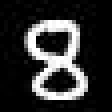

In [4]:
digits_image_dictionary[8][ :, :, 10] # how does the indexing work? This is the 10th example of the digit "8"

Next, let's partition the `digits_image_dictionary::Dict{Int, Array{N0f8,3}}` into training and testing datasets. We randomly select `number_of_training_examples::Int` images per digit for training, and the remaining images are used for testing. In each case, we convert the $28\times 28$ images into vector format by linearizing the matrix into a vector of 784 pixels.

Let's start with the training dataset. 

> __What is vectorization?__ Each $N\times N$ image array containing grayscale values at each pixel is converted to an $N^{2}$ vector by concatenating pixel values. The image class (the digit it represents) is converted to [one-hot format](https://en.wikipedia.org/wiki/One-hot). 

Let's save the training data in the `training_image_dataset::Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}}` variable.


In [ ]:
training_image_dataset = let

    # initialize -
    training_image_dataset = Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}}();
    for i ∈ number_digit_array
        Y = onehot(i, number_digit_array); # what image class is this?
        X = digits_image_dictionary[i]; # this gets ALL images of digit "i"

        for t ∈ 1:number_of_training_examples
            D = reshape(transpose(X[:,:,t]) |> Matrix, number_of_pixels) |> vec; # flatten
            training_tuple = (D,Y); # create training tuple (image data, image class)
            push!(training_image_dataset,training_tuple);
        end
    end
    training_image_dataset; # return
end


Next, we load `number_of_test_examples::Int` images from the `digits_image_dictionary::Dict{Int, Array{N0f8,3}}` for testing purposes. We save the test data in the `testing_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable.


In [ ]:
testing_image_dataset = let
    
    # initialize -
    testing_image_dataset = Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}}()
    
    # main -
    for i ∈ number_digit_array
        Y = onehot(i, number_digit_array); # what image class is this?
        X = digits_image_dictionary[i]; # this gets ALL images of digit "i"
        
        for t ∈ (number_of_training_examples+1):number_of_examples

            D = reshape(transpose(X[:,:,t]) |> Matrix, number_of_pixels) |> vec; # flatten
            testing_tuple = (D,Y); # create testing tuple (image data, image class)
            push!(testing_image_dataset, testing_tuple);
        end
    end

    testing_image_dataset; # return
end;


## Task 1: Create the One versus the Rest (OvR) Dataset
In this task, we create one binary dataset per digit. For a chosen digit `k`, we set the label to `+1` when the image shows digit `k`, and to `-1` otherwise.

> __Implementation note__:
>
> The logistic regression learner in this package uses a finite-difference approximation of the gradient. This is computationally expensive for 784-pixel images. To keep the lab interactive, we:
>
> * Downsample each $28\times 28$ image into a $7\times 7$ average-pooled image (49 features).
> * Build a balanced dataset with a small number of positive and negative examples per digit.

We store the results in two dictionaries: `ovr_training_dataset` and `ovr_testing_dataset`. Each dictionary maps a digit to a tuple `(X, y)` where `X` is the feature matrix and `y` is the $\pm 1$ label vector.


In [ ]:
using Random

# reproducibility
Random.seed!(123);

# downsample configuration (28x28 -> 7x7)
pool = 4;
ovr_training_positive = 200;
ovr_training_negative = 200;
ovr_testing_positive = 100;
ovr_testing_negative = 100;

function downsample_image(x::Vector{Float64}, pool::Int)::Vector{Float64}

    # undo the earlier transpose used during vectorization
    img = reshape(x, (number_of_cols, number_of_rows))';
    new_rows = number_of_rows ÷ pool;
    new_cols = number_of_cols ÷ pool;
    pooled = zeros(Float64, new_rows, new_cols);

    for i ∈ 1:new_rows
        for j ∈ 1:new_cols
            r = (pool*(i-1)+1):(pool*i);
            c = (pool*(j-1)+1):(pool*j);
            pooled[i,j] = mean(img[r,c]);
        end
    end

    return vec(pooled);
end;

function build_ovr_dataset(image_dataset::Vector{Tuple{Vector{Float64}, OneHotVector{UInt32}}},
    digit::Int; number_positive::Int = 200, number_negative::Int = 200, pool::Int = 4)

    # collect indices for positive/negative classes
    pos_idx = Int[];
    neg_idx = Int[];
    for (i,(x,y_onehot)) ∈ enumerate(image_dataset)
        label = number_digit_array[argmax(y_onehot)];
        if (label == digit)
            push!(pos_idx, i);
        else
            push!(neg_idx, i);
        end
    end

    # sample a balanced subset
    pos_sel = pos_idx[randperm(length(pos_idx))[1:number_positive]];
    neg_sel = neg_idx[randperm(length(neg_idx))[1:number_negative]];
    selected = vcat(pos_sel, neg_sel);
    selected = selected[randperm(length(selected))];

    # allocate feature matrix and label vector
    features_per_image = (number_of_rows ÷ pool) * (number_of_cols ÷ pool);
    X = Array{Float64,2}(undef, length(selected), features_per_image);
    y = Array{Int64,1}(undef, length(selected));

    for (k, idx) ∈ enumerate(selected)
        x, y_onehot = image_dataset[idx];
        X[k,:] = downsample_image(x, pool);
        label = number_digit_array[argmax(y_onehot)];
        y[k] = (label == digit) ? 1 : -1;
    end

    return X, y;
end;

ovr_training_dataset, ovr_testing_dataset = let

    # initialize -
    training_dict = Dict{Int, Tuple{Array{Float64,2}, Vector{Int64}}}();
    testing_dict = Dict{Int, Tuple{Array{Float64,2}, Vector{Int64}}}();

    # build datasets for each digit
    for digit ∈ number_digit_array
        Xtr, ytr = build_ovr_dataset(training_image_dataset, digit,
            number_positive = ovr_training_positive,
            number_negative = ovr_training_negative,
            pool = pool
        );
        Xte, yte = build_ovr_dataset(testing_image_dataset, digit,
            number_positive = ovr_testing_positive,
            number_negative = ovr_testing_negative,
            pool = pool
        );
        training_dict[digit] = (Xtr, ytr);
        testing_dict[digit] = (Xte, yte);
    end

    # return -
    training_dict, testing_dict
end;


___


## Task 2: Train an OvR Logistic Regression Model for Each Digit
In this task, we train one binary logistic regression model per digit using the datasets from Task 1. We keep the models in the `ovr_model_dictionary::Dict{Int, MyLogisticRegressionClassificationModel}` dictionary.

> __Training loop__: For each digit, we add a bias term to the feature matrix, build a `MyLogisticRegressionClassificationModel`, and learn the parameters using gradient descent.


> __Time-limited option (offline training)__:
>
> You can train once, save the model dictionary to disk, and reload it during the lab session.
> If you change the downsampling factor (`pool`) or the dataset sizes, you should retrain and re-save.


In [ ]:
digits_to_train = number_digit_array; # change this if you want to train fewer digits

models_file = joinpath(_PATH_TO_DATA, "ovr_logistic_models.jld2");
use_pretrained = true; # set to false to force retraining
train_if_missing = true; # if pretrained file is missing, should we train?

ovr_model_dictionary = let

    if (use_pretrained == true && isfile(models_file))
        @load models_file ovr_model_dictionary
        ovr_model_dictionary
    elseif (train_if_missing == true)

        # training hyperparameters
        maxiter = 150;
        ϵ = 1e-3;
        α = 0.05;
        T = 1.0;
        λ = 0.0;

        model_dictionary = Dict{Int, MyLogisticRegressionClassificationModel}();

        for digit ∈ digits_to_train
            X, y = ovr_training_dataset[digit];
            number_of_examples = size(X,1);
            Xb = [X ones(number_of_examples)];
            number_of_features = size(Xb,2);

            loss_function = (x,y,θ) -> log(1+exp(-2*y*T*(dot(x,θ)))) + λ*norm(θ,2)^2;

            model = build(MyLogisticRegressionClassificationModel, (
                parameters = 0.01*ones(number_of_features),
                learning_rate = α,
                ϵ = ϵ,
                loss_function = loss_function
            ));

            trained = learn(Xb, y, model, maxiter = maxiter, verbose = true);
            model_dictionary[digit] = trained;
        end

        # save for offline use
        mkpath(_PATH_TO_DATA);
        ovr_model_dictionary = model_dictionary;
        @save models_file ovr_model_dictionary

        model_dictionary
    else
        error("No pretrained models found at $(models_file). Set `use_pretrained = false` to train.");
    end
end;


___


## Task 3: Evaluate One Digit vs. Rest Using a Confusion Matrix
In this task, we select a digit and evaluate its OvR classifier on the test dataset. We compute predicted labels from the probability matrix and then build the confusion matrix.

> __Reminder__: In this OvR setting, the “positive” class means “is the digit,” and the “negative” class means “is not the digit.”


In [ ]:
function ovr_confusion_for_digit(digit::Int;
    dataset::Dict = ovr_testing_dataset,
    models::Dict = ovr_model_dictionary)

    @assert haskey(dataset, digit) "Digit $(digit) not found in test dataset."
    @assert haskey(models, digit) "Digit $(digit) not found in model dictionary."

    X_test, y_test = dataset[digit];
    number_of_examples = size(X_test,1);
    Xb = [X_test ones(number_of_examples)];
    model = models[digit];

    # compute class probabilities
    P = classify(Xb, model);

    # convert probabilities to ±1 labels
    ŷ = zeros(Int64, number_of_examples);
    for i ∈ 1:number_of_examples
        ŷ[i] = (P[i,1] ≥ P[i,2]) ? 1 : -1;
    end

    CM = confusion(y_test, ŷ);
    accuracy = (CM[1,1] + CM[2,2]) / length(y_test);

    return CM, accuracy, ŷ, y_test, P
end

digit_to_test = 8; # change this to evaluate a different digit
CM_ovr, accuracy_ovr, ŷ_ovr, y_ovr, P_ovr = ovr_confusion_for_digit(digit_to_test);


In [ ]:
CM_ovr = confusion(y_ovr, ŷ_ovr)


In [ ]:
number_of_test_points = length(y_ovr);
correct_prediction = CM_ovr[1,1] + CM_ovr[2,2];
(correct_prediction/number_of_test_points) |> f-> println("Fraction correct: $(f) Fraction incorrect $(1-f)")


___


## Summary 
This lab demonstrated how the OvR strategy converts a multi-class problem into a set of binary logistic regression tasks, one per digit.

> __Key Takeaways:__
>
> * **OvR decomposes multi-class into binary problems:** Each digit gets its own classifier that separates that digit from all others.
> * **Dimensionality control matters in practice:** Downsampling and balanced subsets make gradient-based training feasible while preserving the OvR workflow.
> * **Confusion matrices reveal digit-specific behavior:** Evaluating one digit vs. rest highlights false positives and false negatives for that digit.

OvR provides a simple, scalable template for extending binary classifiers to multi-class datasets.
___
